In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
train = pd.read_csv("split/train.csv")
dev = pd.read_csv("split/dev.csv")
test = pd.read_csv("split/test.csv")

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
TEXT = "aliased_snippet"
RESULT = "is_parent"
COMPANY1= "company1"
COMPANY2 = "company2"

In [99]:
onto_test = pd.read_csv("./processed/test.csv")

In [101]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT]).append(onto_test[TEXT])
corpus.shape

(99974,)

In [103]:
num_words = 39000
max_len = 40

In [104]:
tokenizer  = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(corpus)

In [105]:
def tokenize(data):
    tokenized = tokenizer.texts_to_sequences(data[TEXT])
    tokenized = pad_sequences(tokenized,maxlen=max_len)
    return tokenized

In [106]:
train_tokenized = tokenize(train)

In [107]:
train_tokenized.shape, train_tokenized[0]

((55568, 40),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  137,   23,
           2, 1159,   19,    3,  106,   85, 1006,  137,   23,    2, 1159,
          19,    3,  106,   85, 1006,    2,    5], dtype=int32))

In [108]:
dev_tokenized = tokenize(dev)

In [109]:
dev_tokenized.shape

(15876, 40)

In [110]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, Bidirectional, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [167]:
model = Sequential([
    Embedding(num_words,100, input_length=train_tokenized.shape[1]),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 40, 100)           3900000   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 40, 400)           481600    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 400)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                2064      
__________

In [169]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [170]:
early_stoping = EarlyStopping(patience=2)

In [171]:
checkpoint = ModelCheckpoint(filepath="./models/bi_lstm.h5")

In [183]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=128, epochs=, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 124s 2ms/step - loss: 0.1427 - acc: 0.9470 - val_loss: 0.4017 - val_acc: 0.8661
Epoch 2/10
55568/55568 [==============================] - 123s 2ms/step - loss: 0.0844 - acc: 0.9697 - val_loss: 0.5527 - val_acc: 0.8658
Epoch 3/10
55568/55568 [==============================] - 124s 2ms/step - loss: 0.0586 - acc: 0.9785 - val_loss: 0.5841 - val_acc: 0.8579


In [140]:
test_tokenized = tokenize(test)
test_tokenized.shape

(7939, 40)

In [141]:
from keras.models import load_model

In [142]:
from sklearn.metrics import f1_score

In [165]:
def score_model(model):
    predictions = model.predict(test_tokenized)    
    predictions_binary = np.round(predictions)
    plot_confusion_matrix(test[RESULT], predictions_binary,classes=[0,1], normalize=True) 
    print("F1 score of test is {}".format(f1_score(test[RESULT], predictions_binary)))    

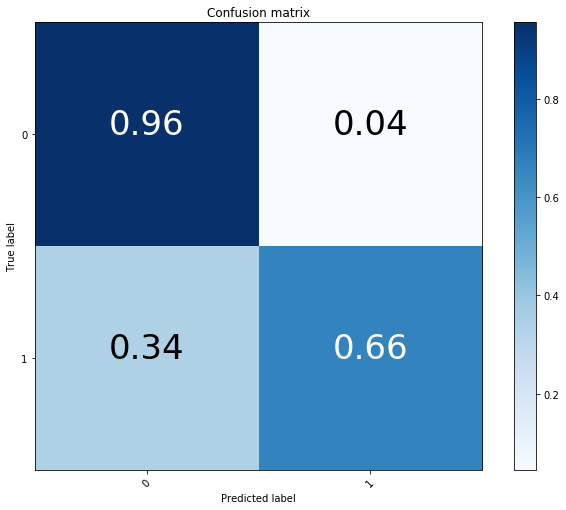

F1 score of test is 0.7483221476510068


In [184]:
score_model(model)

In [174]:
model.save("models/bi_lstm_100_200.h5")

In [175]:
onto_test.shape

(20591, 5)

In [176]:
onto_test[:5]

,company1,company2,is_parent,snippet,aliased_snippet
0,Ford_Motor_Company,Holden,NaN,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
1,Ford_Motor_Company,Holden,NaN,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
2,Apple_Inc.,HBO,NaN,\nGamers who want to access HBO Now on the Xbo...,\ngamers who want to access company2 now on ...
3,Apple_Inc.,HBO,NaN,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...
4,Apple_Inc.,HBO,NaN,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...


In [177]:
onto_test_tokenized = tokenize(onto_test)

In [163]:
%mkdir onto-test

In [178]:
def predict_onto(model, save_name):
    pred = model.predict(onto_test_tokenized)
    onto_test[RESULT] = pred
    onto_test.to_csv("./onto-test/"+save_name)

This is the first baseline model for nn that's why I will save it

In [179]:
predict_onto(model, "bi_lstm.csv")

In [180]:
def show_onto(save_name):
    return pd.read_csv("./onto-test/"+save_name)

In [181]:
pred = show_onto("bi_lstm.csv")

In [182]:
pred[pred["company1"] == "Danaher_Corporation"]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet
311,311,Danaher_Corporation,Pall_Corporation,0.998158,Pall_Corporation is being acquired by Danaher...,company2 is being acquired by company1 ( ...


### Whats next?
The code above was just to clarify everything works as aspected, now lets expolore if adding some CNN filters will improve the score. My hipotesis is by adding convolutions the model will be able to filter only the most useful features and will improve the above score

In [39]:
from keras.layers import Convolution1D,MaxPooling1D, GlobalAveragePooling1D,Flatten, AveragePooling1D
from keras.regularizers import l1,l2

In [64]:
model = Sequential([
    Embedding(num_words,256, input_length=train_tokenized.shape[1]),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 256)           12800000  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total para

In [66]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [67]:
checkpoint = ModelCheckpoint(filepath="./models/conv_bi_lstm.h5")
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=256, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 26s 460us/step - loss: 0.5275 - acc: 0.7332 - val_loss: 0.3941 - val_acc: 0.8250
Epoch 2/10
55568/55568 [==============================] - 23s 412us/step - loss: 0.3089 - acc: 0.8703 - val_loss: 0.3363 - val_acc: 0.8537
Epoch 3/10
55568/55568 [==============================] - 23s 413us/step - loss: 0.1760 - acc: 0.9318 - val_loss: 0.3739 - val_acc: 0.8638
Epoch 4/10
55568/55568 [==============================] - 23s 421us/step - loss: 0.0999 - acc: 0.9637 - val_loss: 0.3928 - val_acc: 0.8643


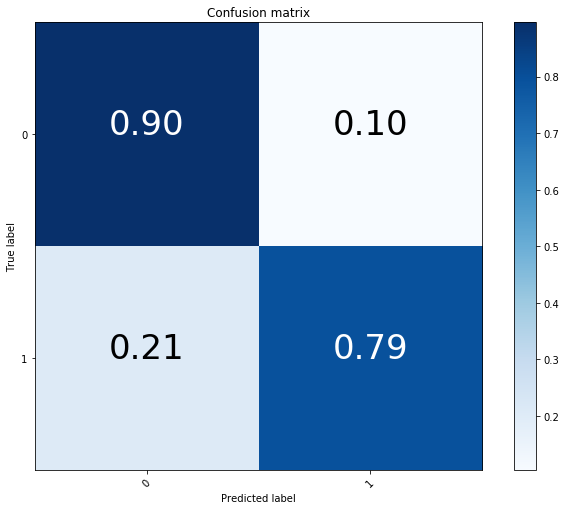

F1 score of test is 0.7788381742738589


In [68]:
score_model(model)